# Binary Classification

Este es un template de como manejariamos un modelo de clasificación con algoritmos de Boosting

Es importante setear antes de iniciar algunas variables de entorno

#### Linux / MAC

```{bash}
export BUCKET_MODEL=belc-bigdata-models-dlk-qas
export FOLDER_MODEL=template-model
export ENV_DEPLOY=QAS
export MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com
```



In [6]:
%env BUCKET_MODEL=belc-bigdata-models-dlk-qas
%env FOLDER_MODEL=template-model
%env ENV_DEPLOY=QAS
%env MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com.

env: BUCKET_MODEL=belc-bigdata-models-dlk-qas
env: FOLDER_MODEL=template-model
env: ENV_DEPLOY=QAS
env: MLFLOW_HOST=internal-alb-datalake-casetwo-qas-45252694.us-east-1.elb.amazonaws.com.


In [7]:
import os
import source.utils.mlflow as ml
from datetime import datetime
import source.utils.configvariables as uc

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Configuracion MLFlow

Seteamos algunas variable principales para iniciar nuestro proyecto

In [ ]:
ml_flow_host = uc.env_ml_flow_host
ml_flow_project = uc.env_ml_flow_project

In [ ]:
Myflow = ml.MLFlowTracking(ml_flow_host)

In [12]:
run_name = 'Propensity_Boosting'
folder = 'propensity'
seed = 12345

## Iniciamos el experimento

Iniciamos el experimiento en la herramienta mlflow

In [ ]:
active_run = Myflow.start_experiment(ml_flow_project, run_name=run_name)
active_run

In [ ]:
dict_tags = {"Enviroment":uc.env_deploy,
             "Grupo":"Template",
             "Proyecto":"Propensity"}

Myflow.model_logging_tags(dict_tags)

In [ ]:
dict_params = {"pipeline":"validation",
               "country":"CORP"}

Myflow.model_logging_params(dict_params)

In [ ]:
start_model = datetime.now()
current_time = start_model.strftime("%H:%M:%S")
print("Current Time is :", current_time)

# registramos el inicio del train
dict_params = {"train_time1_start":current_time}
Myflow.model_logging_params(dict_params)

### bases

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [50]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [51]:
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

In [52]:
from sklearn import set_config

set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['embarked', 'sex', 'pclass'])])

In [53]:
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## modeling

In [61]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt

In [55]:
dtrain =  xgb.DMatrix(data=X_train, label = y_train)
dtest  = xgb.DMatrix(data=X_test,   label = y_test)

watch_list  = [(dtrain,'train'),(dtest,'test')]
params = {'eval_metric': 'auc', 'gamma': 0, 'max_depth': 3, 'min_child_weight': 10, 'objective': 'reg:logistic', 'seed': 2020}


xgb_fit = xgb.train(params = params, dtrain = dtrain, 
                    num_boost_round = 1000, early_stopping_rounds = 20, 
                    evals = watch_list, verbose_eval=1)

[0]	train-auc:0.83774	test-auc:0.85852
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[1]	train-auc:0.84031	test-auc:0.86323
[2]	train-auc:0.84170	test-auc:0.86700
[3]	train-auc:0.84967	test-auc:0.87733
[4]	train-auc:0.85048	test-auc:0.87644
[5]	train-auc:0.84969	test-auc:0.87662
[6]	train-auc:0.85303	test-auc:0.87624
[7]	train-auc:0.85311	test-auc:0.87724
[8]	train-auc:0.85539	test-auc:0.89124
[9]	train-auc:0.85940	test-auc:0.89342
[10]	train-auc:0.86002	test-auc:0.89354
[11]	train-auc:0.86564	test-auc:0.89480
[12]	train-auc:0.86602	test-auc:0.89339
[13]	train-auc:0.86883	test-auc:0.88268
[14]	train-auc:0.87117	test-auc:0.88495
[15]	train-auc:0.87055	test-auc:0.88130
[16]	train-auc:0.87184	test-auc:0.88206
[17]	train-auc:0.87454	test-auc:0.88630
[18]	train-auc:0.87633	test-auc:0.88771
[19]	train-auc:0.87748	test-auc:0.88733
[20]	train-auc:0.87919	test-auc:0.88874
[21]	train-auc:0.88043	test-a

In [56]:
probs_train = xgb_fit.predict(dtrain, ntree_limit = xgb_fit.best_iteration)
probs_val = xgb_fit.predict(dval, ntree_limit = xgb_fit.best_iteration)

In [65]:
auc_train = roc_auc_score(y_train, probs_train)
auc_test = roc_auc_score(y_test, probs_val)

print(f'auc_train: {auc_train:.6f} \tauc_val: {auc_test:.6f}')

auc_train: 0.860022 	auc_val: 0.893538


## find the best threshold

In [59]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

prec, recall, threshold = precision_recall_curve(y_train, probs_train)
prec_recall = pd.DataFrame({'prec': prec[:-1], 'recall': recall[:-1], 'threshold': threshold})
prec_recall['f1'] = 2*prec_recall['prec']*prec_recall['recall'] / (prec_recall['prec'] + prec_recall['recall'])
prec_recall = prec_recall.sort_values(by = 'f1', ascending = False)
prec_recall

,prec,recall,threshold,f1
76,0.742268,0.753927,0.371558,0.748052
75,0.734694,0.753927,0.360667,0.744186
79,0.746702,0.740838,0.379146,0.743758
73,0.728643,0.759162,0.354296,0.743590
81,0.751337,0.735602,0.379479,0.743386
...,...,...,...,...
155,1.000000,0.120419,0.933602,0.214953
156,1.000000,0.115183,0.935257,0.206573
157,1.000000,0.062827,0.935999,0.118227
158,1.000000,0.057592,0.940053,0.108911


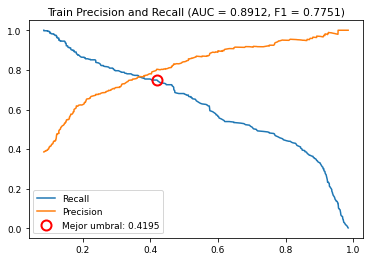

In [88]:
y_train_pred = xgb_fit.predict(dtrain)
auc = roc_auc_score(y_train, y_train_pred)

precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
precision, recall = precision[:-1], recall[:-1]

f1 = 2*precision*recall / (precision + recall)
best_f1_index = f1.argmax()
best_f1 = f1[best_f1_index]
best_threshold = thresholds[best_f1_index]

plt.rcParams.update({'font.size': 9})
plt.plot(thresholds, recall, label= ("Recall"))
plt.plot(thresholds, precision, label= ("Precision"))
plt.title((f"Train Precision and Recall (AUC = {auc:.4f}, F1 = {best_f1:.4f})"))

plt.plot(thresholds[best_f1_index], recall[best_f1_index], 'o', markersize=10,
         label=f"Mejor umbral: {best_threshold:.4f}", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)
plt.show()

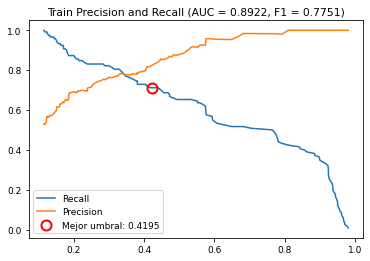

In [89]:
y_test_pred = xgb_fit.predict(dtest)
auc = roc_auc_score(y_test, y_test_pred)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
precision, recall = precision[:-1], recall[:-1]

plt.rcParams.update({'font.size': 9})
plt.plot(thresholds, recall, label= ("Recall"))
plt.plot(thresholds, precision, label= ("Precision"))
plt.title((f"Train Precision and Recall (AUC = {auc:.4f}, F1 = {best_f1:.4f})"))

plt.plot(umbrales[np.abs(thresholds - best_threshold).argmin()], recall[np.abs(umbrales - best_threshold).argmin()], 'o', markersize=10,
         label=f"Mejor umbral: {best_threshold:.4f}", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)
plt.show()

In [ ]:
end_model = datetime.now()
current_time = end_model.strftime("%H:%M:%S")

# registramos el fin del train
dict_params = {"train_time2_end":current_time}
Myflow.model_logging_params(dict_params)

dif_time = end_model-start_model
# registramos el diferencia del train
dict_params = {"train_time3_duration":dif_time}
Myflow.model_logging_params(dict_params)

In [ ]:
dict_metrics = {"auc_train":auc_train, "score_test":auc_test, 
                "best_threshold": best_threshold, "best_f1": best_f1}
Myflow.model_logging_metrics(dict_metrics)

In [ ]:
Myflow.end_experiment()